In [1]:
%cd yolov5


/home/veccam/Documents/Venkat/Mosquito Detection YOLOv5/yolov5


In [2]:
import torch

/home/veccam/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pip install roboflow

In [4]:
%ls

data/         LICENSE                 README.md         tutorial.ipynb
detect.py     models/                 requirements.txt  utils/
Dockerfile    Mosquito-Detection-10/  runs/             weights/
get_crops.py  predictions.csv         test.py           yolo_model.pt
hubconf.py    __pycache__/            train.py


In [5]:

from roboflow import Roboflow
rf = Roboflow(api_key="qqvNIT7iZdFusvy5Rzkp")
project = rf.workspace("venkat-mukthineni").project("mosquito-detection-fqch7")
dataset = project.version(11).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Extracting Dataset Version Zip to Mosquito-Detection-11 in yolov5pytorch:: 100%|


In [6]:
%cat Mosquito-Detection-11/data.yaml

names:
- mosquito
nc: 1
roboflow:
  license: CC BY 4.0
  project: mosquito-detection-fqch7
  url: https://universe.roboflow.com/venkat-mukthineni/mosquito-detection-fqch7/dataset/11
  version: 11
  workspace: venkat-mukthineni
test: ../test/images
train: Mosquito-Detection-11/train/images
val: Mosquito-Detection-11/valid/images


In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial 
%cat models/yolov5s.yaml


# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [2]:
!pip install pycocotools


In [6]:
!pip install Cython

  Using cached Cython-0.29.32-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (2.0 MB)


# training

In [11]:
# train yolov5s on custom data for 100 epochs
# time its performance

!python train.py --img 1280 --batch 8 --epochs 1000 --data ./Mosquito-Detection-11/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --device 0,1

github: skipping check (not a git repository)
YOLOv5  torch 1.11.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11011.0625MB)
                     CUDA:1 (NVIDIA GeForce RTX 2080 Ti, 11019.4375MB)

Namespace(weights='', cfg='./models/custom_yolov5s.yaml', data='./Mosquito-Detection-11/data.yaml', hyp='data/hyp.scratch.yaml', epochs=1000, batch_size=8, img_size=[1280, 1280], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0,1', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, log_imgs=16, log_artifacts=False, workers=8, project='runs/train', entity=None, name='yolov5s_results', exist_ok=False, quad=False, linear_lr=False, world_size=1, global_rank=-1, save_dir='runs/train/yolov5s_results2', total_batch_size=8)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http

     7/999     3.12G    0.0281   0.01794         0   0.04605        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.551       0.548       0.459      0.0879

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
     8/999     3.12G   0.02631   0.01736         0   0.04367        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.329       0.353       0.206      0.0325

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
     9/999     3.12G   0.02634   0.01704         0   0.04338        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.311       0.373       0.202      0.0311

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.262       0.234       0.102      0.0154

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    32/999     3.12G   0.02257   0.01388         0   0.03645        23      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.261       0.285       0.129      0.0207

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    33/999     3.12G   0.02235   0.01385         0    0.0362        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.252       0.291       0.138      0.0241

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    34/999     3.12G   0.02255   0.01389         0   0.03644        22


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    56/999     3.12G   0.02116   0.01321         0   0.03436        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.247       0.251      0.0997      0.0167

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    57/999     3.12G   0.02131   0.01326         0   0.03457        13      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.334       0.347       0.173      0.0271

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    58/999     3.12G   0.02112   0.01335         0   0.03447        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.234       0.248      0.0943  

    80/999     3.12G   0.02048   0.01317         0   0.03365        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.313       0.291       0.165      0.0282

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    81/999     3.12G   0.02005   0.01287         0   0.03292        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.241       0.234       0.106       0.019

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
    82/999     3.12G    0.0209   0.01313         0   0.03404        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.328       0.319        0.18       0.031

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.568       0.554       0.427      0.0679

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   105/999     3.12G   0.02046   0.01282         0   0.03328        15      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.613       0.578       0.488      0.0857

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   106/999     3.12G   0.02003   0.01281         0   0.03284        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.539       0.531       0.413      0.0732

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   107/999     3.12G   0.01967   0.01257         0   0.03224        15


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   129/999     3.12G   0.02004   0.01274         0   0.03278        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.64       0.605       0.534      0.0992

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   130/999     3.12G   0.02012   0.01273         0   0.03285        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.699       0.664       0.609       0.106

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   131/999     3.12G   0.01934    0.0126         0   0.03194        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.633       0.629       0.528  

   153/999     3.12G   0.01923    0.0125         0   0.03173        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.707       0.661       0.637       0.132

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   154/999     3.12G   0.01953   0.01258         0    0.0321        10      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.687       0.701       0.653       0.131

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   155/999     3.12G   0.01981   0.01253         0   0.03233        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.663       0.678       0.612       0.124

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.807       0.768       0.768       0.172

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   178/999     3.12G   0.01882   0.01212         0   0.03094        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.795       0.791       0.782       0.178

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   179/999     3.12G   0.01919   0.01232         0   0.03152        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.781       0.765       0.756       0.165

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   180/999     3.12G   0.01938   0.01229         0   0.03166        16


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   202/999     3.12G   0.01877   0.01223         0     0.031        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.812       0.771       0.778       0.178

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   203/999     3.12G   0.01916   0.01205         0    0.0312        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.794       0.768       0.766       0.177

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   204/999     3.12G    0.0191   0.01228         0   0.03138        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.779       0.777       0.763  

   226/999     3.12G   0.01862   0.01198         0   0.03059        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.808       0.782       0.776       0.167

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   227/999     3.12G   0.01887   0.01215         0   0.03102        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.828       0.762       0.778       0.167

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   228/999     3.12G   0.01904   0.01226         0   0.03131        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.808       0.774       0.769       0.165

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.778       0.732       0.721       0.157

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   251/999     3.12G   0.01872   0.01216         0   0.03088        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.774       0.729        0.72       0.157

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   252/999     3.12G    0.0183   0.01215         0   0.03044        21      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.776       0.734       0.725       0.158

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   253/999     3.12G   0.01867   0.01214         0   0.03081        17


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   275/999     3.12G   0.01842   0.01186         0   0.03028        12      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.765       0.743       0.712        0.16

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   276/999     3.12G   0.01893   0.01216         0   0.03109        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.76       0.742       0.707       0.162

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   277/999     3.12G   0.01862   0.01211         0   0.03073        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.762        0.74       0.707  

   299/999     3.12G   0.01823   0.01199         0   0.03022        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.764       0.723       0.685       0.154

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   300/999     3.12G   0.01852   0.01189         0   0.03041        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.764       0.723       0.686       0.154

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   301/999     3.12G   0.01784   0.01184         0   0.02968        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.764       0.723       0.686       0.155

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.75       0.737       0.689       0.149

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   324/999     3.12G   0.01796   0.01175         0   0.02971        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.75       0.737       0.689       0.149

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   325/999     3.12G   0.01806   0.01168         0   0.02973        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.754       0.729       0.687       0.148

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   326/999     3.12G   0.01822   0.01191         0   0.03014        19


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   348/999     3.12G   0.01806   0.01161         0   0.02967        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.737       0.715       0.673       0.144

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   349/999     3.12G   0.01829   0.01194         0   0.03023        13      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.742       0.706       0.667       0.144

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   350/999     3.12G   0.01779   0.01188         0   0.02967        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.735       0.712       0.667  

   372/999     3.12G    0.0178   0.01165         0   0.02945        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.738       0.708       0.669       0.142

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   373/999     3.12G   0.01818   0.01176         0   0.02994        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.737       0.703       0.665       0.142

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   374/999     3.12G   0.01775   0.01175         0    0.0295        23      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.73       0.712       0.665       0.141

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.719       0.709       0.654       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   397/999     3.12G    0.0181   0.01186         0   0.02996        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.722       0.712       0.656       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   398/999     3.12G   0.01778   0.01157         0   0.02935        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.725       0.709       0.656       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   399/999     3.12G   0.01752   0.01147         0     0.029        17


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   421/999     3.12G   0.01763   0.01183         0   0.02946        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.721       0.709       0.645       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   422/999     3.12G   0.01802    0.0116         0   0.02961        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.718       0.706       0.643       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   423/999     3.12G   0.01767   0.01173         0    0.0294        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.716       0.706       0.643  

   445/999     3.12G   0.01762   0.01135         0   0.02897        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.734       0.695       0.646       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   446/999     3.12G   0.01717   0.01139         0   0.02856        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.734       0.695       0.645       0.135

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   447/999     3.12G   0.01732   0.01129         0   0.02861        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.726       0.703       0.645       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.722       0.698       0.637       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   470/999     3.12G   0.01744   0.01156         0     0.029        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.722       0.698       0.637       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   471/999     3.12G   0.01701   0.01124         0   0.02825        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.722       0.698       0.637       0.134

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   472/999     3.12G   0.01693   0.01143         0   0.02836        11


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   494/999     3.12G   0.01666   0.01137         0   0.02803        22      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.745       0.711       0.657       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   495/999     3.12G    0.0174   0.01111         0   0.02851        15      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.745       0.711       0.657       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   496/999     3.12G   0.01786   0.01141         0   0.02927        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.744       0.715       0.658  

   518/999     3.12G    0.0169   0.01127         0   0.02818        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.74       0.709       0.648       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   519/999     3.12G   0.01711   0.01118         0   0.02828        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.735       0.706       0.646       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   520/999     3.12G    0.0168   0.01131         0   0.02811        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.732       0.703       0.642       0.135

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.741       0.703        0.64       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   543/999     3.12G   0.01677   0.01138         0   0.02815        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.74       0.703       0.643       0.137

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   544/999     3.12G   0.01689   0.01116         0   0.02805        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.74       0.703       0.643       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   545/999     3.12G   0.01648   0.01095         0   0.02743        20


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   567/999     3.12G   0.01641     0.011         0   0.02741        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.738         0.7       0.643       0.136

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   568/999     3.12G   0.01676   0.01125         0   0.02801        25      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.738         0.7       0.645       0.137

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   569/999     3.12G   0.01665   0.01109         0   0.02774        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.738       0.701       0.643  

   591/999     3.12G   0.01646   0.01112         0   0.02757        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.76       0.714       0.664       0.141

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   592/999     3.12G   0.01607   0.01127         0   0.02734        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.757       0.712       0.657        0.14

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   593/999     3.12G    0.0169   0.01111         0   0.02801        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.757       0.712       0.657        0.14

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.746       0.706        0.65       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   616/999     3.12G   0.01673   0.01108         0   0.02781        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.749       0.701        0.65       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   617/999     3.12G   0.01645   0.01118         0   0.02763        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.749       0.701        0.65       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   618/999     3.12G   0.01627   0.01093         0    0.0272         9


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   640/999     3.12G   0.01633   0.01091         0   0.02724        23      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.732       0.703       0.632       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   641/999     3.12G   0.01607    0.0109         0   0.02697        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.746       0.689       0.634       0.139

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   642/999     3.12G   0.01638   0.01072         0    0.0271        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.746       0.689       0.633  

   664/999     3.12G   0.01627   0.01098         0   0.02725        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.737       0.703       0.638       0.142

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   665/999     3.12G   0.01625   0.01095         0    0.0272        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.738       0.703       0.638       0.142

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   666/999     3.12G   0.01639   0.01092         0   0.02731        22      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.738       0.701       0.638       0.142

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.735       0.703        0.64       0.143

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   689/999     3.12G   0.01584    0.0108         0   0.02663        21      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.737       0.703       0.639       0.143

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   690/999     3.12G   0.01618   0.01072         0    0.0269        13      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.737       0.703       0.641       0.144

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   691/999     3.12G   0.01598    0.0108         0   0.02678        21


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   713/999     3.12G   0.01567   0.01085         0   0.02652        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.734       0.708       0.641       0.144

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   714/999     3.12G   0.01572   0.01085         0   0.02657        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.745         0.7       0.641       0.144

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   715/999     3.12G   0.01632   0.01083         0   0.02715        21      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.745         0.7       0.641  

   737/999     3.12G   0.01593   0.01065         0   0.02658        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.744       0.706       0.654       0.151

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   738/999     3.12G   0.01551   0.01067         0   0.02618        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.747       0.709       0.657       0.151

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   739/999     3.12G   0.01579    0.0107         0   0.02649        12      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.747       0.709       0.657       0.151

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.766       0.712       0.675       0.154

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   762/999     3.12G     0.016   0.01055         0   0.02655        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.739       0.737       0.675       0.155

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   763/999     3.12G   0.01573    0.0106         0   0.02633        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.76       0.723        0.68       0.155

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   764/999     3.12G   0.01596   0.01069         0   0.02665        15


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   786/999     3.12G   0.01547   0.01053         0     0.026        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.76       0.726       0.687       0.157

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   787/999     3.12G   0.01567   0.01072         0   0.02638        18      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.764       0.723       0.687       0.157

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   788/999     3.12G   0.01532    0.0106         0   0.02592        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354        0.76       0.726       0.687  

   810/999     3.12G   0.01583   0.01057         0   0.02641        21      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.772       0.737       0.694       0.161

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   811/999     3.12G   0.01527   0.01036         0   0.02563        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.772       0.737       0.694       0.161

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   812/999     3.12G   0.01523   0.01045         0   0.02568        16      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.772       0.737       0.694       0.162

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.782        0.74       0.698       0.164

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   835/999     3.12G   0.01551   0.01051         0   0.02602        11      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.779       0.737       0.697       0.165

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   836/999     3.12G   0.01527   0.01033         0    0.0256        15      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.782        0.74         0.7       0.165

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   837/999     3.12G   0.01557   0.01029         0   0.02587        19


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   859/999     3.12G   0.01566   0.01038         0   0.02605        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.815        0.76       0.729        0.17

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   860/999     3.12G   0.01548   0.01024         0   0.02573        13      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.811       0.763       0.728        0.17

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   861/999     3.12G   0.01522   0.01042         0   0.02564        15      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.808        0.76       0.726  

   883/999     3.12G   0.01539   0.01047         0   0.02586        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.818       0.777       0.739       0.175

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   884/999     3.12G   0.01501   0.01008         0   0.02509        15      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.816       0.777        0.74       0.175

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   885/999     3.12G   0.01505   0.01044         0   0.02549        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.815       0.774       0.735       0.174

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.828        0.78       0.747       0.178

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   908/999     3.12G   0.01477   0.01022         0     0.025        13      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.829        0.78       0.747       0.178

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   909/999     3.12G   0.01539   0.01057         0   0.02596        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.829        0.78       0.747       0.178

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   910/999     3.12G   0.01474    0.0102         0   0.02494        14


     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   932/999     3.12G   0.01472   0.01031         0   0.02503        15      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.835       0.788       0.751       0.182

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   933/999     3.12G   0.01473   0.01018         0   0.02491        14      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.831       0.794       0.751       0.182

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   934/999     3.12G   0.01483   0.01014         0   0.02498        10      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.831       0.794       0.751  

   956/999     3.12G   0.01486   0.01012         0   0.02498        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.829       0.793       0.752       0.187

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   957/999     3.12G   0.01478    0.0102         0   0.02497        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.829       0.794       0.752       0.187

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   958/999     3.12G    0.0149   0.01017         0   0.02506        19      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.829       0.794       0.753       0.188

     Epoch   gpu_mem       box       obj       cls     total   targets

               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.836       0.799       0.759       0.191

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   981/999     3.12G   0.01489   0.01017         0   0.02507        20      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.834       0.796       0.755        0.19

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   982/999     3.12G   0.01521   0.01023         0   0.02544        17      1280
               Class      Images     Targets           P           R      mAP@.5
                 all         354         354       0.837       0.799        0.76       0.191

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
   983/999     3.12G   0.01494    0.0102         0   0.02514        21

# Evaluation

In [11]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [6]:
from IPython.display import Image, clear_output 

from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='./runs/train/yolov5s_results4/results.png', width=1000)  # view results.png

ModuleNotFoundError: No module named 'utils'

# Sample Ground truth Data

GROUND TRUTH TRAINING DATA:


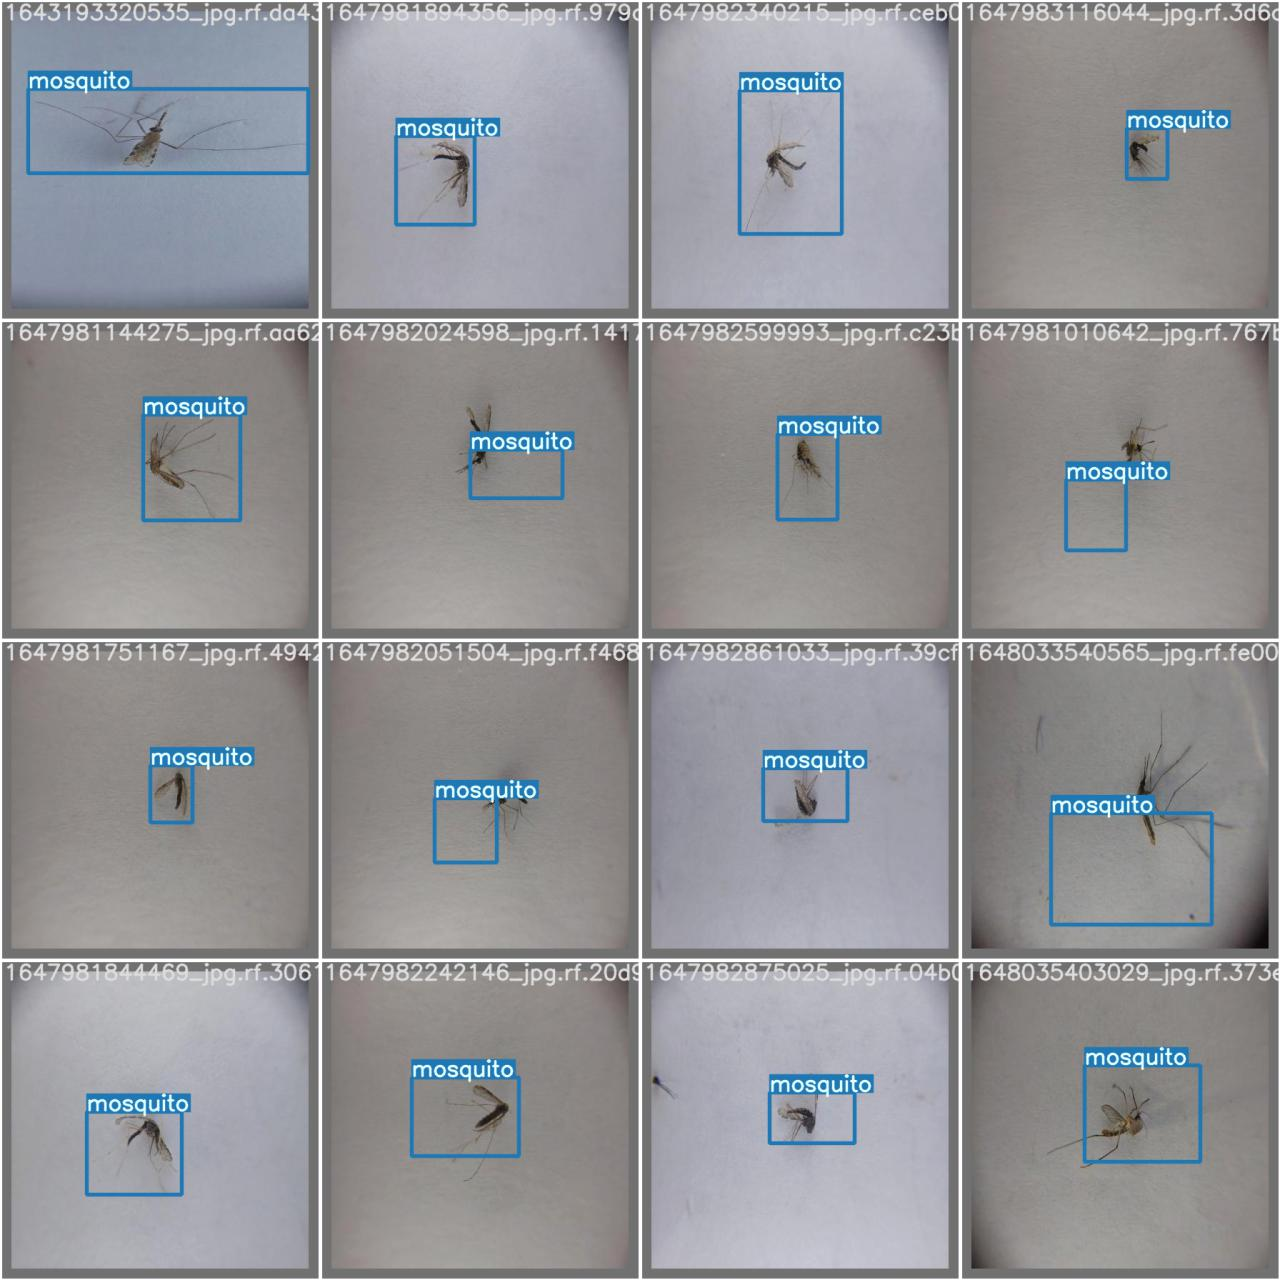

In [59]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='./runs/train/yolov5s_results2/test_batch0_labels.jpg', width=900)

# Detection on test data

In [12]:
%cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/home/veccam/Documents/Venkat/Mosquito Detection YOLOv5/yolov5


In [4]:
# !python detect.py --weights runs/train/yolov5s_results6/weights/best.pt --conf 0.03 --source "/home/venkat/Downloads/Uganda Technical Validation/media/" --save-txt --save-conf

Namespace(weights=['runs/train/yolov5s_results6/weights/best.pt'], source='/home/venkat/Downloads/Uganda Technical Validation/media/', img_size=640, conf_thres=0.03, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=True, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False)
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11177.1875MB)
                                      CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11178.5MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
/home/venkat/anaconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/489 /home/venkat/D

image 38/489 /home/venkat/Downloads/Uganda Technical Validation/media/044_2-15_33_56.jpg: x1:  53
y1:  11
x2:  1177
y2:  770
Image Name:  044_2-15_33_56.jpg
appended
448x640 1 mosquito, Done. (0.009s)
image 39/489 /home/venkat/Downloads/Uganda Technical Validation/media/044_3-15_34_3.jpg: x1:  147
y1:  0
x2:  1142
y2:  800
Image Name:  044_3-15_34_3.jpg
appended
448x640 1 mosquito, Done. (0.009s)
image 40/489 /home/venkat/Downloads/Uganda Technical Validation/media/045_1-15_34_27.jpg: x1:  59
y1:  0
x2:  1198
y2:  800
Image Name:  045_1-15_34_27.jpg
appended
448x640 1 mosquito, Done. (0.009s)
image 41/489 /home/venkat/Downloads/Uganda Technical Validation/media/045_2-15_34_34.jpg: x1:  0
y1:  0
x2:  1181
y2:  800
Image Name:  045_2-15_34_34.jpg
appended
448x640 1 mosquito, Done. (0.009s)
image 42/489 /home/venkat/Downloads/Uganda Technical Validation/media/045_3-15_34_40.jpg: x1:  0
y1:  3
x2:  1181
y2:  800
Image Name:  045_3-15_34_40.jpg
appended
448x640 1 mosquito, Done. (0.009s)
im

image 80/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659723852547.jpg: x1:  184
y1:  1044
x2:  1458
y2:  2461
Image Name:  1659723852547.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 81/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659723883776.jpg: x1:  77
y1:  777
x2:  1799
y2:  1794
Image Name:  1659723883776.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 82/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659723894102.jpg: x1:  218
y1:  297
x2:  1174
y2:  1227
Image Name:  1659723894102.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 83/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659723951232.jpg: x1:  245
y1:  293
x2:  1166
y2:  1249
Image Name:  1659723951232.jpg
appended
640x480 2 mosquitos, Done. (0.011s)
image 84/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659723952229.jpg: x1:  245
y1:  293
x2:  1166
y2:  1249
Image Name:  1659723952229.jpg
appended
640x480 Done. (0.009s)
i

image 121/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659724437308.jpg: x1:  711
y1:  1159
x2:  1657
y2:  2118
Image Name:  1659724437308.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 122/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659724446453.jpg: x1:  7
y1:  26
x2:  1200
y2:  1162
Image Name:  1659724446453.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 123/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659724454847.jpg: x1:  694
y1:  1115
x2:  1774
y2:  2163
Image Name:  1659724454847.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 124/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659724550131.jpg: x1:  1115
y1:  559
x2:  2123
y2:  1571
Image Name:  1659724550131.jpg
appended
480x640 1 mosquito, Done. (0.010s)
image 125/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659724569031.jpg: x1:  0
y1:  0
x2:  1200
y2:  1600
Image Name:  1659724569031.jpg
appended
640x480 1 mosquito, Done

image 162/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725040828.jpg: x1:  837
y1:  209
x2:  2341
y2:  1589
Image Name:  1659725040828.jpg
appended
480x640 1 mosquito, Done. (0.010s)
image 163/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725048046.jpg: x1:  0
y1:  398
x2:  1200
y2:  1440
Image Name:  1659725048046.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 164/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725054350.jpg: x1:  0
y1:  398
x2:  1200
y2:  1440
Image Name:  1659725054350.jpg
appended
640x480 Done. (0.009s)
image 165/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725057346.jpg: x1:  996
y1:  492
x2:  2231
y2:  1477
Image Name:  1659725057346.jpg
appended
480x640 1 mosquito, Done. (0.010s)
image 166/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725062799.jpg: x1:  65
y1:  640
x2:  1678
y2:  2520
Image Name:  1659725062799.jpg
appended
640x480 1 mosquito, Done. (0.010s)
im

image 203/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725545024.jpg: x1:  19
y1:  2293
x2:  2163
y2:  2995
Image Name:  1659725545024.jpg
appended
640x480 2 mosquitos, Done. (0.010s)
image 204/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725552349.jpg: x1:  16
y1:  2292
x2:  2166
y2:  2995
Image Name:  1659725552349.jpg
appended
640x480 2 mosquitos, Done. (0.010s)
image 205/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725575436.jpg: x1:  38
y1:  92
x2:  1173
y2:  1309
Image Name:  1659725575436.jpg
appended
640x480 2 mosquitos, Done. (0.010s)
image 206/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725594980.jpg: x1:  38
y1:  92
x2:  1173
y2:  1309
Image Name:  1659725594980.jpg
appended
640x480 Done. (0.009s)
image 207/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659725599770.jpg: x1:  38
y1:  92
x2:  1173
y2:  1309
Image Name:  1659725599770.jpg
appended
640x480 Done. (0.009s)
image 208/48

image 244/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726325878.jpg: x1:  11
y1:  0
x2:  2250
y2:  3000
Image Name:  1659726325878.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 245/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726341147.jpg: x1:  362
y1:  1183
x2:  2215
y2:  2904
Image Name:  1659726341147.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 246/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726342635.jpg: x1:  0
y1:  0
x2:  2250
y2:  1083
Image Name:  1659726342635.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 247/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726364243.jpg: x1:  866
y1:  610
x2:  1785
y2:  1434
Image Name:  1659726364243.jpg
appended
480x640 1 mosquito, Done. (0.010s)
image 248/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726369539.jpg: x1:  6
y1:  15
x2:  2236
y2:  2054
Image Name:  1659726369539.jpg
appended
640x480 1 mosquito, Done. (0.

image 285/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726762885.jpg: x1:  962
y1:  223
x2:  2184
y2:  1341
Image Name:  1659726762885.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 286/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726821690.jpg: x1:  761
y1:  998
x2:  1570
y2:  1713
Image Name:  1659726821690.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 287/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726847736.jpg: x1:  385
y1:  583
x2:  855
y2:  953
Image Name:  1659726847736.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 288/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726848289.jpg: x1:  1036
y1:  1143
x2:  1863
y2:  1857
Image Name:  1659726848289.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 289/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659726852498.jpg: x1:  0
y1:  898
x2:  2234
y2:  2937
Image Name:  1659726852498.jpg
appended
640x480 1 mosquito, Do

image 326/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727254457.jpg: x1:  10
y1:  0
x2:  1664
y2:  1296
Image Name:  1659727254457.jpg
appended
640x480 2 mosquitos, Done. (0.010s)
image 327/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727255634.jpg: x1:  1074
y1:  441
x2:  2154
y2:  1480
Image Name:  1659727255634.jpg
appended
480x640 1 mosquito, Done. (0.010s)
image 328/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727265967.jpg: x1:  752
y1:  1455
x2:  1566
y2:  2175
Image Name:  1659727265967.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 329/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727267320.jpg: x1:  1129
y1:  614
x2:  1905
y2:  1726
Image Name:  1659727267320.jpg
appended
480x640 1 mosquito, Done. (0.010s)
image 330/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727283998.jpg: x1:  696
y1:  681
x2:  1969
y2:  1624
Image Name:  1659727283998.jpg
appended
480x640 2 mosquitos

image 367/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727732928.jpg: x1:  49
y1:  1632
x2:  1317
y2:  2752
Image Name:  1659727732928.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 368/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727746331.jpg: x1:  46
y1:  1631
x2:  1330
y2:  2752
Image Name:  1659727746331.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 369/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727754989.jpg: x1:  47
y1:  1641
x2:  1322
y2:  2747
Image Name:  1659727754989.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 370/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727840398.jpg: x1:  141
y1:  1526
x2:  1521
y2:  2738
Image Name:  1659727840398.jpg
appended
640x480 1 mosquito, Done. (0.010s)
image 371/489 /home/venkat/Downloads/Uganda Technical Validation/media/1659727861373.jpg: x1:  67
y1:  1574
x2:  1242
y2:  2798
Image Name:  1659727861373.jpg
appended
640x480 1 mosquito,

image 407/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_21_32_Pro-14_22_25.jpg: x1:  2
y1:  0
x2:  640
y2:  466
Image Name:  WIN_20220805_14_21_32_Pro-14_22_25.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 408/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_22_04_Pro-14_22_29.jpg: x1:  12
y1:  0
x2:  639
y2:  480
Image Name:  WIN_20220805_14_22_04_Pro-14_22_29.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 409/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_23_20_Pro-14_24_58.jpg: x1:  7
y1:  0
x2:  634
y2:  475
Image Name:  WIN_20220805_14_23_20_Pro-14_24_58.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 410/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_23_53_Pro-14_25_1.jpg: x1:  0
y1:  11
x2:  639
y2:  477
Image Name:  WIN_20220805_14_23_53_Pro-14_25_1.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 411/489 /home/venkat/Downloads/Uganda 

image 444/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_48_10_Pro-14_48_30.jpg: x1:  0
y1:  0
x2:  548
y2:  474
Image Name:  WIN_20220805_14_48_10_Pro-14_48_30.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 445/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_49_56_Pro-14_50_51.jpg: x1:  2
y1:  0
x2:  620
y2:  475
Image Name:  WIN_20220805_14_49_56_Pro-14_50_51.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 446/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_50_02_Pro-14_50_54.jpg: x1:  5
y1:  5
x2:  640
y2:  460
Image Name:  WIN_20220805_14_50_02_Pro-14_50_54.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 447/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_14_50_10_Pro-14_51_5.jpg: x1:  6
y1:  4
x2:  348
y2:  466
Image Name:  WIN_20220805_14_50_10_Pro-14_51_5.jpg
appended
480x640 2 mosquitos, Done. (0.009s)
image 448/489 /home/venkat/Downloads/Uganda T

image 480/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_15_11_23_Pro-15_11_42.jpg: x1:  0
y1:  0
x2:  628
y2:  463
Image Name:  WIN_20220805_15_11_23_Pro-15_11_42.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 481/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_15_12_38_Pro-15_15_25.jpg: x1:  53
y1:  0
x2:  640
y2:  479
Image Name:  WIN_20220805_15_12_38_Pro-15_15_25.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 482/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_15_12_50_Pro-15_15_29.jpg: x1:  3
y1:  11
x2:  619
y2:  476
Image Name:  WIN_20220805_15_12_50_Pro-15_15_29.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 483/489 /home/venkat/Downloads/Uganda Technical Validation/media/WIN_20220805_15_12_57_Pro-15_15_32.jpg: x1:  9
y1:  2
x2:  640
y2:  472
Image Name:  WIN_20220805_15_12_57_Pro-15_15_32.jpg
appended
480x640 1 mosquito, Done. (0.009s)
image 484/489 /home/venkat/Downloads/Ugand

In [16]:
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --conf 0.03 --source "/home/veccam/Documents/Remus/VecCAM/M5_odk" --save-txt --save-conf

Namespace(weights=['runs/train/yolov5s_results2/weights/best.pt'], source='/home/veccam/Documents/Remus/VecCAM/M5_odk', img_size=640, conf_thres=0.03, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=True, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False)
YOLOv5  torch 1.11.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11011.0625MB)
                     CUDA:1 (NVIDIA GeForce RTX 2080 Ti, 11019.4375MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
/home/veccam/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/166

image 39/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660382021998.jpg: x1:  466
y1:  799
x2:  1386
y2:  1784
Image Name:  1660382021998.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 40/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660382062344.jpg: x1:  183
y1:  386
x2:  1685
y2:  1997
Image Name:  1660382062344.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 41/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660382079732.jpg: x1:  229
y1:  725
x2:  1775
y2:  2394
Image Name:  1660382079732.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 42/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660382100212.jpg: x1:  23
y1:  527
x2:  1798
y2:  2299
Image Name:  1660382100212.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 43/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660382130122.jpg: x1:  567
y1:  848
x2:  2250
y2:  2377
Image Name:  1660382130122.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 44/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk

image 83/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660383221449.jpg: x1:  279
y1:  298
x2:  1748
y2:  2154
Image Name:  1660383221449.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 84/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660383236638.jpg: x1:  281
y1:  536
x2:  2175
y2:  2047
Image Name:  1660383236638.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 85/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660383262953.jpg: x1:  1093
y1:  835
x2:  2232
y2:  2142
Image Name:  1660383262953.jpg
appended
640x480 1 mosquito, Done. (0.009s)
image 86/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660383279208.jpg: x1:  565
y1:  950
x2:  1784
y2:  2309
Image Name:  1660383279208.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 87/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660383295535.jpg: x1:  626
y1:  1044
x2:  1896
y2:  2254
Image Name:  1660383295535.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 88/1392 /home/veccam/Documents/Remus/VecCAM/M5_

image 127/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660384300636.jpg: x1:  200
y1:  949
x2:  1164
y2:  2116
Image Name:  1660384300636.jpg
appended
640x480 1 mosquito, Done. (0.008s)
image 128/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660384324889.jpg: x1:  772
y1:  640
x2:  2020
y2:  1623
Image Name:  1660384324889.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 129/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660384342095.jpg: x1:  745
y1:  1083
x2:  1669
y2:  1952
Image Name:  1660384342095.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 130/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660384389513.jpg: x1:  819
y1:  1496
x2:  1504
y2:  2155
Image Name:  1660384389513.jpg
appended
640x480 1 mosquito, Done. (0.133s)
image 131/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660384410519.jpg: x1:  1014
y1:  1386
x2:  1672
y2:  2017
Image Name:  1660384410519.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 132/1392 /home/veccam/Documents/Remus/Ve

image 171/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660385835127.jpg: x1:  325
y1:  1402
x2:  1484
y2:  2466
Image Name:  1660385835127.jpg
appended
640x480 1 mosquito, Done. (0.007s)
image 172/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660385870321.jpg: x1:  212
y1:  420
x2:  1580
y2:  1725
Image Name:  1660385870321.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 173/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660385887343.jpg: x1:  654
y1:  868
x2:  2013
y2:  2188
Image Name:  1660385887343.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 174/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660385907200.jpg: x1:  299
y1:  475
x2:  1652
y2:  1866
Image Name:  1660385907200.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 175/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660385950859.jpg: x1:  90
y1:  108
x2:  1477
y2:  1380
Image Name:  1660385950859.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 176/1392 /home/veccam/Documents/Remus/VecCAM

image 215/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660402631642.jpg: x1:  602
y1:  1177
x2:  1545
y2:  2100
Image Name:  1660402631642.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 216/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660402660740.jpg: x1:  558
y1:  671
x2:  1649
y2:  1979
Image Name:  1660402660740.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 217/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660402676353.jpg: x1:  525
y1:  1328
x2:  1624
y2:  2468
Image Name:  1660402676353.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 218/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660402696944.jpg: x1:  491
y1:  516
x2:  1543
y2:  1805
Image Name:  1660402696944.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 219/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660402708482.jpg: x1:  711
y1:  888
x2:  1823
y2:  1875
Image Name:  1660402708482.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 220/1392 /home/veccam/Documents/Remus/VecC

image 258/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660403624385.jpg: x1:  1144
y1:  575
x2:  2536
y2:  1889
Image Name:  1660403624385.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 259/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660403642912.jpg: x1:  535
y1:  691
x2:  1770
y2:  2088
Image Name:  1660403642912.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 260/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660403657921.jpg: x1:  251
y1:  577
x2:  1493
y2:  2041
Image Name:  1660403657921.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 261/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660403658789.jpg: x1:  612
y1:  1175
x2:  2018
y2:  2620
Image Name:  1660403658789.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 262/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660403663487.jpg: x1:  1310
y1:  838
x2:  2407
y2:  2029
Image Name:  1660403663487.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 263/1392 /home/veccam/Documents/Remus/Ve

image 301/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660404449852.jpg: x1:  846
y1:  800
x2:  1770
y2:  1737
Image Name:  1660404449852.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 302/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660404485423.jpg: x1:  883
y1:  336
x2:  2243
y2:  1724
Image Name:  1660404485423.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 303/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660404518348.jpg: x1:  316
y1:  1016
x2:  1542
y2:  2019
Image Name:  1660404518348.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 304/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660404538107.jpg: x1:  450
y1:  852
x2:  1514
y2:  1818
Image Name:  1660404538107.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 305/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660404572304.jpg: x1:  1044
y1:  473
x2:  1836
y2:  1173
Image Name:  1660404572304.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 306/1392 /home/veccam/Documents/Remus/VecC

image 345/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660405365709.jpg: x1:  418
y1:  1184
x2:  1396
y2:  2224
Image Name:  1660405365709.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 346/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660405373669.jpg: x1:  924
y1:  1096
x2:  2248
y2:  2430
Image Name:  1660405373669.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 347/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660405382051.jpg: x1:  991
y1:  1057
x2:  1985
y2:  2173
Image Name:  1660405382051.jpg
appended
640x480 1 mosquito, Done. (0.007s)
image 348/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660405385391.jpg: x1:  197
y1:  1106
x2:  1534
y2:  2370
Image Name:  1660405385391.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 349/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660405390911.jpg: x1:  492
y1:  469
x2:  1663
y2:  1920
Image Name:  1660405390911.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 350/1392 /home/veccam/Documents/Remus/Ve

image 388/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660406022125.jpg: x1:  689
y1:  1058
x2:  1772
y2:  2200
Image Name:  1660406022125.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 389/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660406030531.jpg: x1:  572
y1:  1789
x2:  1724
y2:  2953
Image Name:  1660406030531.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 390/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660406040451.jpg: x1:  718
y1:  358
x2:  1916
y2:  1514
Image Name:  1660406040451.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 391/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660406040455.jpg: x1:  742
y1:  1097
x2:  1836
y2:  2248
Image Name:  1660406040455.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 392/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660406043991.jpg: x1:  569
y1:  703
x2:  1766
y2:  2114
Image Name:  1660406043991.jpg
appended
640x480 1 mosquito, Done. (0.008s)
image 393/1392 /home/veccam/Documents/Remus/Vec

image 431/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407020732.jpg: x1:  875
y1:  9
x2:  2618
y2:  1717
Image Name:  1660407020732.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 432/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407041585.jpg: x1:  287
y1:  89
x2:  1962
y2:  1823
Image Name:  1660407041585.jpg
appended
480x640 1 mosquito, Done. (0.005s)
image 433/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407057462.jpg: x1:  701
y1:  919
x2:  1663
y2:  1920
Image Name:  1660407057462.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 434/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407070940.jpg: x1:  784
y1:  122
x2:  2143
y2:  1624
Image Name:  1660407070940.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 435/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407122550.jpg: x1:  491
y1:  1350
x2:  1364
y2:  2234
Image Name:  1660407122550.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 436/1392 /home/veccam/Documents/Remus/VecCAM/M

image 475/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407500395.jpg: x1:  627
y1:  879
x2:  1625
y2:  2034
Image Name:  1660407500395.jpg
appended
640x480 1 mosquito, Done. (0.009s)
image 476/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407507992.jpg: x1:  1242
y1:  248
x2:  2318
y2:  1472
Image Name:  1660407507992.jpg
appended
480x640 1 mosquito, Done. (0.008s)
image 477/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407511530.jpg: x1:  674
y1:  536
x2:  1915
y2:  1883
Image Name:  1660407511530.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 478/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407517435.jpg: x1:  605
y1:  1166
x2:  1741
y2:  2235
Image Name:  1660407517435.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 479/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660407522088.jpg: x1:  824
y1:  874
x2:  2064
y2:  2114
Image Name:  1660407522088.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 480/1392 /home/veccam/Documents/Remus/VecC

image 519/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660408309726.jpg: x1:  620
y1:  242
x2:  1954
y2:  1716
Image Name:  1660408309726.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 520/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660408334729.jpg: x1:  929
y1:  618
x2:  2122
y2:  1796
Image Name:  1660408334729.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 521/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660408356451.jpg: x1:  114
y1:  278
x2:  1451
y2:  1420
Image Name:  1660408356451.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 522/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660408372744.jpg: x1:  1180
y1:  451
x2:  2447
y2:  1646
Image Name:  1660408372744.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 523/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660408392961.jpg: x1:  664
y1:  676
x2:  2002
y2:  2142
Image Name:  1660408392961.jpg
appended
480x640 1 mosquito, Done. (0.005s)
image 524/1392 /home/veccam/Documents/Remus/VecCA

image 562/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660409145046.jpg: x1:  355
y1:  1289
x2:  1747
y2:  2864
Image Name:  1660409145046.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 563/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660409172387.jpg: x1:  431
y1:  1277
x2:  1427
y2:  2313
Image Name:  1660409172387.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 564/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660409173695.jpg: x1:  369
y1:  1150
x2:  1675
y2:  2655
Image Name:  1660409173695.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 565/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660409189494.jpg: x1:  501
y1:  1242
x2:  1838
y2:  2409
Image Name:  1660409189494.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 566/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660409199629.jpg: x1:  121
y1:  1475
x2:  1391
y2:  2639
Image Name:  1660409199629.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 567/1392 /home/veccam/Documents/Remus/V

image 606/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660409982701.jpg: x1:  597
y1:  1629
x2:  1614
y2:  2576
Image Name:  1660409982701.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 607/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660410001303.jpg: x1:  762
y1:  893
x2:  1758
y2:  1835
Image Name:  1660410001303.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 608/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660410015808.jpg: x1:  350
y1:  619
x2:  1727
y2:  1969
Image Name:  1660410015808.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 609/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660410016611.jpg: x1:  736
y1:  528
x2:  1713
y2:  1447
Image Name:  1660410016611.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 610/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660410037927.jpg: x1:  533
y1:  941
x2:  1962
y2:  2279
Image Name:  1660410037927.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 611/1392 /home/veccam/Documents/Remus/VecCA

image 650/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660481987637.jpg: x1:  537
y1:  1015
x2:  1829
y2:  2055
Image Name:  1660481987637.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 651/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660482017269.jpg: x1:  643
y1:  1250
x2:  1890
y2:  2677
Image Name:  1660482017269.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 652/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660482088953.jpg: x1:  663
y1:  1040
x2:  2149
y2:  2147
Image Name:  1660482088953.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 653/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660482108366.jpg: x1:  819
y1:  1230
x2:  2005
y2:  2184
Image Name:  1660482108366.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 654/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660482127247.jpg: x1:  532
y1:  1202
x2:  1741
y2:  2374
Image Name:  1660482127247.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 655/1392 /home/veccam/Documents/Remus/V

image 693/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660484405024.jpg: x1:  772
y1:  1373
x2:  1808
y2:  2344
Image Name:  1660484405024.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 694/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660484429334.jpg: x1:  333
y1:  1219
x2:  1629
y2:  2545
Image Name:  1660484429334.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 695/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660484452261.jpg: x1:  470
y1:  1568
x2:  1965
y2:  3000
Image Name:  1660484452261.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 696/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660484470627.jpg: x1:  270
y1:  1377
x2:  1403
y2:  2452
Image Name:  1660484470627.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 697/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660484838461.jpg: x1:  4
y1:  543
x2:  1447
y2:  1991
Image Name:  1660484838461.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 698/1392 /home/veccam/Documents/Remus/VecC

image 736/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660486944848.jpg: x1:  653
y1:  1093
x2:  1954
y2:  2289
Image Name:  1660486944848.jpg
appended
640x480 1 mosquito, Done. (0.007s)
image 737/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660486966366.jpg: x1:  758
y1:  1238
x2:  2020
y2:  2520
Image Name:  1660486966366.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 738/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660486981845.jpg: x1:  790
y1:  1009
x2:  1493
y2:  1719
Image Name:  1660486981845.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 739/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660487018574.jpg: x1:  410
y1:  1054
x2:  1753
y2:  2060
Image Name:  1660487018574.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 740/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660487032261.jpg: x1:  513
y1:  795
x2:  1622
y2:  1976
Image Name:  1660487032261.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 741/1392 /home/veccam/Documents/Remus/Ve

image 779/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660489612994.jpg: x1:  515
y1:  1233
x2:  2128
y2:  2639
Image Name:  1660489612994.jpg
appended
640x480 1 mosquito, Done. (0.008s)
image 780/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660489624826.jpg: x1:  738
y1:  1114
x2:  1934
y2:  2171
Image Name:  1660489624826.jpg
appended
640x480 1 mosquito, Done. (0.008s)
image 781/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660489662551.jpg: x1:  758
y1:  1196
x2:  1932
y2:  2184
Image Name:  1660489662551.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 782/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660489676454.jpg: x1:  875
y1:  1295
x2:  1915
y2:  2303
Image Name:  1660489676454.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 783/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660489697309.jpg: x1:  851
y1:  1545
x2:  1741
y2:  2353
Image Name:  1660489697309.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 784/1392 /home/veccam/Documents/Remus/V

image 823/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660492180466.jpg: x1:  726
y1:  1062
x2:  2241
y2:  2442
Image Name:  1660492180466.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 824/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660492195771.jpg: x1:  169
y1:  835
x2:  1664
y2:  2243
Image Name:  1660492195771.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 825/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660492209894.jpg: x1:  666
y1:  684
x2:  1755
y2:  1969
Image Name:  1660492209894.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 826/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660492235143.jpg: x1:  618
y1:  1191
x2:  1850
y2:  2255
Image Name:  1660492235143.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 827/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660492249870.jpg: x1:  993
y1:  553
x2:  2181
y2:  1845
Image Name:  1660492249870.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 828/1392 /home/veccam/Documents/Remus/VecC

image 866/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660716327113.jpg: x1:  923
y1:  1212
x2:  1505
y2:  1720
Image Name:  1660716327113.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 867/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660716342579.jpg: x1:  1055
y1:  1167
x2:  1650
y2:  1690
Image Name:  1660716342579.jpg
appended
640x480 1 mosquito, Done. (0.007s)
image 868/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660716662790.jpg: x1:  190
y1:  950
x2:  1453
y2:  2045
Image Name:  1660716662790.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 869/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660716702149.jpg: x1:  738
y1:  1262
x2:  1896
y2:  2459
Image Name:  1660716702149.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 870/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660716777756.jpg: x1:  625
y1:  1514
x2:  1876
y2:  2548
Image Name:  1660716777756.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 871/1392 /home/veccam/Documents/Remus/V

image 909/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660718298795.jpg: x1:  929
y1:  1349
x2:  2039
y2:  2452
Image Name:  1660718298795.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 910/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660718365479.jpg: x1:  765
y1:  1070
x2:  1820
y2:  2202
Image Name:  1660718365479.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 911/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660718377259.jpg: x1:  532
y1:  679
x2:  1603
y2:  1832
Image Name:  1660718377259.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 912/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660718386728.jpg: x1:  639
y1:  1138
x2:  1629
y2:  2132
Image Name:  1660718386728.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 913/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660718413242.jpg: x1:  757
y1:  1267
x2:  1795
y2:  2319
Image Name:  1660718413242.jpg
appended
640x480 1 mosquito, Done. (0.008s)
image 914/1392 /home/veccam/Documents/Remus/Ve

image 952/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660721495500.jpg: x1:  673
y1:  1389
x2:  1357
y2:  2050
Image Name:  1660721495500.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 953/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660721513771.jpg: x1:  683
y1:  1308
x2:  1361
y2:  2002
Image Name:  1660721513771.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 954/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660721529300.jpg: x1:  1043
y1:  1113
x2:  1748
y2:  1802
Image Name:  1660721529300.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 955/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660721612735.jpg: x1:  929
y1:  1349
x2:  1603
y2:  1979
Image Name:  1660721612735.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 956/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660721630678.jpg: x1:  739
y1:  1271
x2:  1358
y2:  1944
Image Name:  1660721630678.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 957/1392 /home/veccam/Documents/Remus/

image 995/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660724707047.jpg: x1:  695
y1:  1015
x2:  1530
y2:  1880
Image Name:  1660724707047.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 996/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660724725075.jpg: x1:  847
y1:  867
x2:  1685
y2:  1770
Image Name:  1660724725075.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 997/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660724817303.jpg: x1:  676
y1:  727
x2:  2108
y2:  2393
Image Name:  1660724817303.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 998/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660724837320.jpg: x1:  137
y1:  799
x2:  1871
y2:  2337
Image Name:  1660724837320.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 999/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660724947468.jpg: x1:  313
y1:  458
x2:  1976
y2:  2033
Image Name:  1660724947468.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1000/1392 /home/veccam/Documents/Remus/VecC

image 1038/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660726527096.jpg: x1:  135
y1:  1048
x2:  1903
y2:  2730
Image Name:  1660726527096.jpg
appended
640x480 1 mosquito, Done. (0.007s)
image 1039/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660726568471.jpg: x1:  783
y1:  69
x2:  2250
y2:  1566
Image Name:  1660726568471.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1040/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660726595238.jpg: x1:  248
y1:  977
x2:  1863
y2:  2538
Image Name:  1660726595238.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1041/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660726606167.jpg: x1:  458
y1:  444
x2:  2145
y2:  2066
Image Name:  1660726606167.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1042/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660726687254.jpg: x1:  179
y1:  59
x2:  1725
y2:  1582
Image Name:  1660726687254.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1043/1392 /home/veccam/Documents/Remus/V

image 1081/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660727665664.jpg: x1:  527
y1:  602
x2:  2046
y2:  2430
Image Name:  1660727665664.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1082/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660727669485.jpg: x1:  919
y1:  539
x2:  2114
y2:  1884
Image Name:  1660727669485.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1083/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660727686082.jpg: x1:  0
y1:  654
x2:  1847
y2:  1969
Image Name:  1660727686082.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1084/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660727686376.jpg: x1:  735
y1:  1120
x2:  2020
y2:  2316
Image Name:  1660727686376.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1085/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660727708428.jpg: x1:  438
y1:  885
x2:  1941
y2:  2510
Image Name:  1660727708428.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1086/1392 /home/veccam/Documents/Remus/V

image 1124/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660812095051.jpg: x1:  153
y1:  1424
x2:  1608
y2:  2723
Image Name:  1660812095051.jpg
appended
640x480 1 mosquito, Done. (0.009s)
image 1125/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660812110593.jpg: x1:  350
y1:  1286
x2:  1777
y2:  2803
Image Name:  1660812110593.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1126/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660812154029.jpg: x1:  335
y1:  947
x2:  1624
y2:  2290
Image Name:  1660812154029.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1127/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660812176124.jpg: x1:  458
y1:  1219
x2:  1814
y2:  2747
Image Name:  1660812176124.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1128/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660812192007.jpg: x1:  612
y1:  1058
x2:  1955
y2:  2550
Image Name:  1660812192007.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1129/1392 /home/veccam/Documents/Re

image 1167/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660901462187.jpg: x1:  408
y1:  207
x2:  2205
y2:  1826
Image Name:  1660901462187.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1168/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660901498334.jpg: x1:  178
y1:  434
x2:  1901
y2:  2032
Image Name:  1660901498334.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1169/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660901527950.jpg: x1:  316
y1:  842
x2:  1849
y2:  2241
Image Name:  1660901527950.jpg
appended
640x480 1 mosquito, Done. (0.007s)
image 1170/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660901573422.jpg: x1:  394
y1:  443
x2:  1809
y2:  1985
Image Name:  1660901573422.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1171/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660901621736.jpg: x1:  199
y1:  468
x2:  2250
y2:  2522
Image Name:  1660901621736.jpg
appended
640x480 1 mosquito, Done. (0.008s)
image 1172/1392 /home/veccam/Documents/Remus/

image 1210/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660904523182.jpg: x1:  403
y1:  659
x2:  2060
y2:  2452
Image Name:  1660904523182.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1211/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660904552263.jpg: x1:  465
y1:  908
x2:  2054
y2:  2402
Image Name:  1660904552263.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1212/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660904570696.jpg: x1:  653
y1:  1185
x2:  2238
y2:  2822
Image Name:  1660904570696.jpg
appended
640x480 3 mosquitos, Done. (0.006s)
image 1213/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660904699216.jpg: x1:  670
y1:  1341
x2:  1889
y2:  2456
Image Name:  1660904699216.jpg
appended
640x480 1 mosquito, Done. (0.005s)
image 1214/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1660904719348.jpg: x1:  575
y1:  1084
x2:  1843
y2:  2324
Image Name:  1660904719348.jpg
appended
640x480 1 mosquito, Done. (0.006s)
image 1215/1392 /home/veccam/Documents/Re

image 1253/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661183611847.jpg: x1:  350
y1:  420
x2:  2323
y2:  2234
Image Name:  1661183611847.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1254/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661183657595.jpg: x1:  311
y1:  250
x2:  2459
y2:  2250
Image Name:  1661183657595.jpg
appended
480x640 3 mosquitos, Done. (0.006s)
image 1255/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661183754544.jpg: x1:  680
y1:  91
x2:  2862
y2:  2189
Image Name:  1661183754544.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1256/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661183797922.jpg: x1:  508
y1:  423
x2:  2468
y2:  2174
Image Name:  1661183797922.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1257/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661183843438.jpg: x1:  486
y1:  167
x2:  2738
y2:  2159
Image Name:  1661183843438.jpg
appended
480x640 1 mosquito, Done. (0.005s)
image 1258/1392 /home/veccam/Documents/Remus/

image 1296/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661196066689.jpg: x1:  725
y1:  132
x2:  2032
y2:  1498
Image Name:  1661196066689.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1297/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661196089972.jpg: x1:  1044
y1:  928
x2:  1834
y2:  1695
Image Name:  1661196089972.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1298/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661196103836.jpg: x1:  563
y1:  758
x2:  1411
y2:  1612
Image Name:  1661196103836.jpg
appended
480x640 2 mosquitos, Done. (0.005s)
image 1299/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661196136334.jpg: x1:  804
y1:  986
x2:  1631
y2:  1820
Image Name:  1661196136334.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1300/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661196155654.jpg: x1:  367
y1:  629
x2:  1636
y2:  1835
Image Name:  1661196155654.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1301/1392 /home/veccam/Documents/

image 1339/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661197676757.jpg: x1:  331
y1:  654
x2:  1538
y2:  1896
Image Name:  1661197676757.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1340/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661197697695.jpg: x1:  1179
y1:  748
x2:  1962
y2:  1530
Image Name:  1661197697695.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1341/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661197737463.jpg: x1:  708
y1:  749
x2:  1493
y2:  1520
Image Name:  1661197737463.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1342/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661197772421.jpg: x1:  1570
y1:  357
x2:  2864
y2:  1932
Image Name:  1661197772421.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1343/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661197807707.jpg: x1:  895
y1:  423
x2:  1845
y2:  1413
Image Name:  1661197807707.jpg
appended
480x640 2 mosquitos, Done. (0.006s)
image 1344/1392 /home/veccam/Documents/R

image 1382/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661199501128.jpg: x1:  1182
y1:  628
x2:  2145
y2:  1630
Image Name:  1661199501128.jpg
appended
480x640 1 mosquito, Done. (0.005s)
image 1383/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661199518568.jpg: x1:  824
y1:  472
x2:  1874
y2:  1493
Image Name:  1661199518568.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1384/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661199540528.jpg: x1:  359
y1:  11
x2:  2273
y2:  1563
Image Name:  1661199540528.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1385/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661199560502.jpg: x1:  1008
y1:  310
x2:  2977
y2:  2250
Image Name:  1661199560502.jpg
appended
480x640 1 mosquito, Done. (0.005s)
image 1386/1392 /home/veccam/Documents/Remus/VecCAM/M5_odk/1661199574335.jpg: x1:  735
y1:  659
x2:  2670
y2:  2250
Image Name:  1661199574335.jpg
appended
480x640 1 mosquito, Done. (0.006s)
image 1387/1392 /home/veccam/Documents/Remus

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('./runs/detect/exp1/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")